In [1]:
import numpy as np
import pandas as pd
import pickle


from matplotlib import pyplot as plt
%matplotlib inline 

from utils.train_conformal import train_conformal_forecaster

## Data processing

Energy data
* Predicting the `Appliances` variable
* Splitting the sequence with $T=60$ (10 hours) and $H=12$ (2 hours)

Stock data
* Predicting the `Close` price of ?? stock
* Splitting at higher granularity: $T=30$ and $H=10$ (month and 10 days)

Hungarian chickenpox data
* Predicting the weekly number of cases
* Train on most regions and choose other regions for testing (this can fail because different regions can follow different distributions)
* Choose $T=8$, $H=4$ (given past two months, what is the forecast for the next month)

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
from utils.uci_data_processing import prepare_uci_datasets

In [9]:
prepare_uci_datasets()

Dataset: energy, calibrated: True
Dataset: energy, calibrated: False
Dataset: stock, calibrated: True
Dataset: stock, calibrated: False
Dataset: hungary, calibrated: True
Dataset: hungary, calibrated: False


In [66]:
def plot_ts(dataset, coverages, intervals, idx=None, forecast_only=False):
    fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 8), sharex=True)
    
    if idx is None:
        idx = range(len(dataset))

    for ax in axs.flat:
        i = np.random.choice(idx)
        
        # Derive unpadded sequences and targets
        sequence, target, length = dataset[i]
        
        horizon = min(len(target), length)
        sequence, target = sequence[:length].flatten().tolist(), target[:horizon].flatten().tolist()
        
        if not forecast_only:
            # (Scatter)plot of the time series
            ax.plot(range(1, length+1), sequence, color="black")
            
            # Prediction start vertical
            ax.axvline(length, linestyle="--", color="black")
        
        ax.scatter(range(length + 1, length + horizon + 1), target, color="black")
        
        # Interval boundaries
        lower = [sequence[-1]] + intervals[i, 0].flatten().tolist()[:horizon]
        upper = [sequence[-1]] + intervals[i, 1].flatten().tolist()[:horizon]
        pred = [sequence[-1]] + (intervals[i, 0] + (intervals[i, 1] - intervals[i, 0]) / 2).flatten().tolist()[:horizon]
        
        ax.fill_between(range(length, length + horizon + 1), lower, upper, color="r", alpha=0.25)
        ax.plot(range(length, length + horizon + 1), lower, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), upper, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), pred, linestyle="--", linewidth=3, color="r")

        ax.set(ylabel='Prediction')
    
    plt.xlabel('Time step')
    #     plt.ylabel('Prediction')
    plt.show()

In [86]:
with open('data/stock_calibrated_higher_train_test.pkl', 'rb') as f:
    test_dataset = pickle.load(f)
stock_results = baselines['CoRNN']['stock']

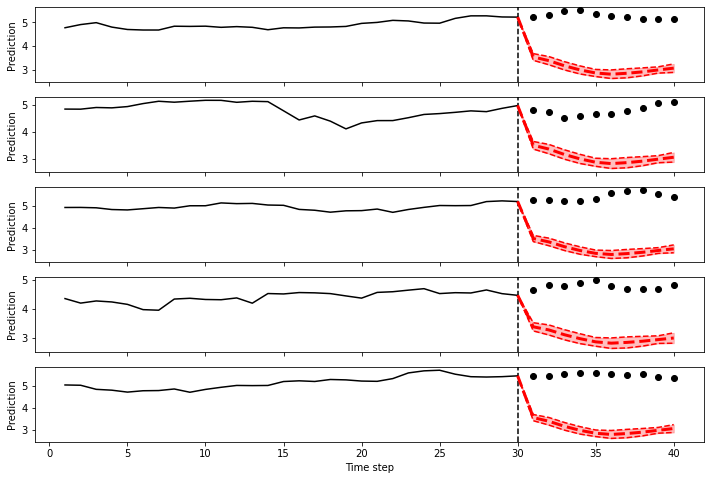

In [87]:
plot_ts(test_dataset, stock_results['coverages'], stock_results['intervals'])

In [17]:
from utils.uci_data_processing import run_uci_experiments
baselines = run_uci_experiments(baselines=['QRNN', 'DPRNN'], retrain=True)

QRNN, energy
Epoch:  0 | train loss: 0.4792
Epoch:  0 | train loss: 0.1978
Epoch:  0 | train loss: 0.1704
Epoch:  0 | train loss: 0.2196
Epoch:  0 | train loss: 0.1953
Epoch:  0 | train loss: 0.1864
Epoch:  0 | train loss: 0.1425
Epoch:  0 | train loss: 0.1838
Epoch:  0 | train loss: 0.1951
Epoch:  0 | train loss: 0.1824
Epoch:  1 | train loss: 0.1911
Epoch:  1 | train loss: 0.1539
Epoch:  1 | train loss: 0.1392
Epoch:  1 | train loss: 0.1810
Epoch:  1 | train loss: 0.1131
Epoch:  1 | train loss: 0.1567
Epoch:  1 | train loss: 0.2113
Epoch:  1 | train loss: 0.1564
Epoch:  1 | train loss: 0.1412
Epoch:  1 | train loss: 0.1429
Epoch:  2 | train loss: 0.1540
Epoch:  2 | train loss: 0.1228
Epoch:  2 | train loss: 0.1545
Epoch:  2 | train loss: 0.1430
Epoch:  2 | train loss: 0.1550
Epoch:  2 | train loss: 0.1426
Epoch:  2 | train loss: 0.1357
Epoch:  2 | train loss: 0.1253
Epoch:  2 | train loss: 0.1589
Epoch:  2 | train loss: 0.1232
Epoch:  3 | train loss: 0.1468
Epoch:  3 | train loss: 0.

In [25]:
baselines = run_uci_experiments(baselines=['CoRNN'], retrain=True)

CoRNN, energy
Epoch: 0	Train loss: 0.8697029607636588
Epoch: 50	Train loss: 0.6368449819939477
CoRNN, stock
Epoch: 0	Train loss: 0.37644054353810275
Epoch: 50	Train loss: 0.009363923275556702
Epoch: 100	Train loss: 0.009251735370176343
Epoch: 150	Train loss: 0.009572926729630966
Epoch: 200	Train loss: 0.008958990990112606
Epoch: 250	Train loss: 0.008904882867892202
Epoch: 300	Train loss: 0.008268369039377341
Epoch: 350	Train loss: 0.007123317014282713
Epoch: 400	Train loss: 0.006455318250048619
Epoch: 450	Train loss: 0.005237145027002463
Epoch: 500	Train loss: 0.005412258315258301
Epoch: 550	Train loss: 0.004580313035358603
Epoch: 600	Train loss: 0.0037649451898267637
Epoch: 650	Train loss: 0.004002160321061428
Epoch: 700	Train loss: 0.004093537913062251
Epoch: 750	Train loss: 0.003024599040285326
Epoch: 800	Train loss: 0.004942499047431808
Epoch: 850	Train loss: 0.002913092585423818
Epoch: 900	Train loss: 0.002873100882145361
Epoch: 950	Train loss: 0.0026468559920501252
CoRNN, hungary

In [30]:
baselines['CoRNN']['hungary']['mean_coverage']

0.9367647171020508

In [29]:
baselines = run_uci_experiments(retrain=False)

CoRNN, energy
QRNN, energy
DPRNN, energy
CoRNN, stock
QRNN, stock
DPRNN, stock
CoRNN, hungary
QRNN, hungary
DPRNN, hungary


In [46]:
for dataset in ['energy', 'stock', 'hungary']:
    print(baselines['QRNN'][dataset]['Coverage'])

0.9118421052631579
0.11094224924012158
0.8947303921568628


In [44]:
for dataset in ['energy', 'stock', 'hungary']:
    widths = baselines['CoRNN'][dataset]['interval_widths']
    print(np.mean(widths), np.std(widths))

7.185693383216858 0.7295036651261846
5.473923110961914 0.1700629499425274
3.1405014991760254 0.166563035124521


In [49]:
ci = baselines['QRNN']['energy']['Confidence intervals']

In [50]:
len(ci)

380

In [53]:
np.mean(ci[1])

0.91411614

In [62]:
for dataset in ['energy', 'stock', 'hungary']:
    ci = baselines['QRNN'][dataset]['Confidence intervals']
    ci_mean = np.mean([np.mean(c) for c in ci])
    ci_std = np.mean([np.std(c) for c in ci])
    print('{:.2f} \\(\\pm\\) {:.2f}'.format(ci_mean, ci_std))

1.76 \(\pm\) 0.46
0.29 \(\pm\) 0.09
1.51 \(\pm\) 0.18


In [71]:
baselines = run_uci_experiments(baselines=['CoRNN'], datasets=['stock'], retrain=True)


CoRNN, stock
Epoch: 0	Train loss: 0.4230421669781208
Epoch: 50	Train loss: 0.009497724885407548
Epoch: 100	Train loss: 0.009157068722953018
Epoch: 150	Train loss: 0.00893707385358329
Epoch: 200	Train loss: 0.008018833047782
Epoch: 250	Train loss: 0.007477487365786846
Epoch: 300	Train loss: 0.006853185701542175
Epoch: 350	Train loss: 0.006226424521838243
Epoch: 400	Train loss: 0.004790516453795135
Epoch: 450	Train loss: 0.0034170312574133277
Epoch: 500	Train loss: 0.0025764880925775147
Epoch: 550	Train loss: 0.0020536567720298013
Epoch: 600	Train loss: 0.002429847520453712
Epoch: 650	Train loss: 0.0023467616993002594
Epoch: 700	Train loss: 0.0017645572079345584
Epoch: 750	Train loss: 0.0017200388650123316
Epoch: 800	Train loss: 0.0017264922050974118
Epoch: 850	Train loss: 0.0012666551808181864
Epoch: 900	Train loss: 0.0011807881304636025
Epoch: 950	Train loss: 0.0011076139187655197


In [84]:
stock_results = baselines['CoRNN']['stock']

In [76]:
from utils.uci_data_processing import prepare_uci_datasets
prepare_uci_datasets(datasets=['stock'], calibrates=[True], suffix='higher_train')

Dataset: stock, calibrated: True


In [83]:
from utils.uci_data_processing import run_uci_experiments
baselines = run_uci_experiments(datasets=['stock'], baselines=['CoRNN'], suffix='higher_train', retrain=True)

CoRNN, stock
Epoch: 0	Train loss: 0.27546990625560286
Epoch: 50	Train loss: 0.007631435695414742
Epoch: 100	Train loss: 0.007075917456919948
Epoch: 150	Train loss: 0.007194480827699105
Epoch: 200	Train loss: 0.007718435713710884
Epoch: 250	Train loss: 0.006590768710399667
Epoch: 300	Train loss: 0.006112052158763011
Epoch: 350	Train loss: 0.006471277688009044
Epoch: 400	Train loss: 0.006155254319310188
Epoch: 450	Train loss: 0.00546047060439984
Epoch: 500	Train loss: 0.0056181696631635225
Epoch: 550	Train loss: 0.003685185293822239
Epoch: 600	Train loss: 0.0044833012313271565
Epoch: 650	Train loss: 0.004892234403329591
Epoch: 700	Train loss: 0.0035428591383000214
Epoch: 750	Train loss: 0.0047069001942873
Epoch: 800	Train loss: 0.004249232425354421
Epoch: 850	Train loss: 0.004152367279554407
Epoch: 900	Train loss: 0.0037406862635786333
Epoch: 950	Train loss: 0.0035796935747688017


In [79]:
baselines['CoRNN']['stock']

{'coverages': tensor([[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False